In [73]:
using Base.Iterators: partition
using BSON
using Flux
using Flux: logitbinarycrossentropy, chunk
using Flux.Data: DataLoader
using Images
using MLDatasets
using Parameters: @with_kw
using Random
using CUDA
using JSON
# using ProgressMeter: Progress, next!
using Plots

device = gpu

const n_patients   = 5366
const DS_PATH      = "../dataset_json/"

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


"../dataset_json/"

In [29]:
# return list of patients with their trajectories
function load_patients()
    patients = []
    for i = 1:n_patients
        p = JSON.parsefile(DS_PATH * "patient_" * string(i) * ".json")
        push!(patients, p) 
    end
    return patients
end

load_patients (generic function with 1 method)

In [30]:
ps = load_patients();

In [31]:
p = ps[1]

Dict{String,Any} with 8 entries:
  "num_observations" => 74
  "mortality"        => true
  "patient_index"    => 1
  "actions"          => Any[21, 21, 1, 1, 1, 1, 1, 1, 1, 21  …  1, 1, 1, 1, 2, …
  "icuid"            => 200003
  "MAP"              => Any[83, 84.5, 68.2, 69.3333, 70, 73, 66, 68, 71, 72  … …
  "cont_actions"     => Any[Any[0.2245, 0.224, 0, 0, 0, 0, 0, 0, 0, 0.225  …  0…
  "trajectory"       => Any[Any[-0.359482, 0.439907, -1.05909, -0.487919, -0.17…

In [32]:
convert(Array{Float32}, [p["trajectory"][1]; p["MAP"][1]] / 100.0)

50-element Array{Float32,1}:
 -0.0035948171
  0.004399074
 -0.010590914
 -0.004879193
 -0.0017430051
 -0.0014888797
 -0.0013654974
 -0.0061029876
 -0.0024194391
  0.0028084475
  0.0015390423
 -0.00062615494
 -0.001839509
  ⋮
  0.0022211785
 -0.001083959
  0.0028033373
  0.002831705
  0.002850545
  0.0034823036
  0.0034936164
  0.0035055524
 -0.0057397964
 -0.0056734793
 -0.0056106304
  0.83

In [33]:

# load MNIST images and return loader
function get_data(batch_size)

    
    xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
    xtrain = reshape(xtrain, 28^2, :)

    println("xtrain:", size(xtrain))
    println("ytrain:", size(ytrain))

    DataLoader(xtrain, ytrain, batchsize = batch_size, shuffle = true)
end

get_data (generic function with 1 method)

In [50]:
loader = get_data(128)

xtrain:(784, 60000)
ytrain:(60000,)


DataLoader{Tuple{Array{Float32,2},Array{Int64,1}}}((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5, 0, 4, 1, 9, 2, 1, 3, 1, 4  …  9, 2, 9, 5, 1, 8, 3, 5, 6, 8]), 128, 60000, true, 60000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  59991, 59992, 59993, 59994, 59995, 59996, 59997, 59998, 59999, 60000], true)

In [35]:
data.data

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5, 0, 4, 1, 9, 2, 1, 3, 1, 4  …  9, 2, 9, 5, 1, 8, 3, 5, 6, 8])

In [36]:
size(data.data[1])

(784, 60000)

In [37]:
size(data.data[2])

(60000,)

In [57]:
struct Encoder
    linear
    μ
    logσ
    Encoder(input_dim, latent_dim, hidden_dim, device) = new(
        Dense(input_dim, hidden_dim, tanh) |> device,   # linear
        Dense(hidden_dim, latent_dim) |> device,        # μ
        Dense(hidden_dim, latent_dim) |> device,        # logσ
    )
end

In [58]:
function (encoder::Encoder)(x)
    h = encoder.linear(x)
    encoder.μ(h), encoder.logσ(h)
end

Decoder(input_dim, latent_dim, hidden_dim, device) = Chain(
    Dense(latent_dim, hidden_dim, tanh),
    Dense(hidden_dim, input_dim)
) |> device


Decoder (generic function with 1 method)

In [59]:

function model_loss(encoder, decoder, λ, x, device)
    μ, logσ, decoder_z = reconstuct(encoder, decoder, x, device)
    len = size(x)[end]
    # KL-divergence
    kl_q_p = 0.5f0 * sum(@. (exp(2f0 * logσ) + μ^2 -1f0 - 2f0 * logσ)) / len

    logp_x_z = -sum(Flux.Losses.logitbinarycrossentropy.(decoder_z, x)) / len
    # regularization
    reg = λ * sum(x->sum(x.^2), Flux.params(decoder))
    
    -logp_x_z + kl_q_p + reg
end

model_loss (generic function with 1 method)

In [60]:
# arguments for the `train` function 
@with_kw mutable struct Args
    η = 1e-3                # learning rate
    λ = 0.01f0              # regularization paramater
    batch_size = 128        # batch size
    sample_size = 10        # sampling size for output    
    epochs = 20             # number of epochs
    seed = 0                # random seed
    cuda = true             # use GPU
    input_dim = 28^2        # image size
    latent_dim = 2          # latent dimension
    hidden_dim = 500        # hidden dimension
    verbose_freq = 10       # logging for every verbose_freq iterations
    tblogger = false        # log training with tensorboard
    save_path = "output"    # results path
end

Args

In [61]:
args = Args()

Args
  η: Float64 0.001
  λ: Float32 0.01f0
  batch_size: Int64 128
  sample_size: Int64 10
  epochs: Int64 20
  seed: Int64 0
  cuda: Bool true
  input_dim: Int64 784
  latent_dim: Int64 2
  hidden_dim: Int64 500
  verbose_freq: Int64 10
  tblogger: Bool false
  save_path: String "output"


In [67]:
println("Initializing VAE model...")
encoder = Encoder(args.input_dim, args.latent_dim, args.hidden_dim, device)
decoder = Decoder(args.input_dim, args.latent_dim, args.hidden_dim, device)

# ADAM optimizer
opt = ADAM(args.η)
    
# parameters
ps = Flux.params(encoder.linear, encoder.μ, encoder.logσ, decoder)

Initializing VAE model...


Params([Float32[-0.05629157 0.0019765513 … -0.026740663 -0.016459309; 0.019565847 0.06537134 … 0.001831043 -0.0356415; … ; 0.0061392616 -0.059736762 … 0.0012227055 0.042512428; -0.058291115 -0.01346821 … -0.033583738 0.0007359506], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.030114414 -0.088389516 … -0.0797802 0.0122500975; 0.02207291 0.037198775 … -0.100582294 -0.07148049], Float32[0.0, 0.0], Float32[-0.05652197 0.016812293 … 0.0977633 0.08435327; -0.01870112 0.09083507 … -0.08048624 -0.02586], Float32[0.0, 0.0], Float32[0.07345263 -0.09072755; -0.08722653 0.08336297; … ; -0.031701848 -0.0070069446; 0.03680998 -0.00523059], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.04288684 -0.028718274 … -0.05480019 0.04143386; 0.037976116 0.037141908 … -0.015737358 -0.042333215; … ; 0.050321758 -0.0280533 … 0.003628871 -0.01624129; 0.04930452 

In [68]:
!ispath(args.save_path) && mkpath(args.save_path)

false

In [69]:
function reconstuct(encoder, decoder, x, device)
    μ, logσ = encoder(x)
    z = μ + device(randn(Float32, size(logσ))) .* exp.(logσ)
    μ, logσ, decoder(z)
end

function convert_to_image(x, y_size)
    Gray.(permutedims(vcat(reshape.(chunk(sigmoid.(x |> cpu), y_size), 28, :)...), (2, 1)))
end

convert_to_image (generic function with 1 method)

In [79]:
# fixed input
original, _ = first(get_data(args.sample_size^2))
original = original |> device

image = convert_to_image(original, args.sample_size)
image_path = joinpath(args.save_path, "original.png")
save(image_path, image)

xtrain:(784, 60000)
ytrain:(60000,)


0

In [71]:
train_steps = 0
train_losses = []
for epoch = 1:args.epochs
    println("Epoch $(epoch)")
    # progress = Progress(length(loader))

    for (x, _) in loader 
        loss, back = Flux.pullback(ps) do
            model_loss(encoder, decoder, args.λ, x |> device, device)
        end
        grad = back(1f0)
        Flux.Optimise.update!(opt, ps, grad)
        # progress meter
        # next!(progress; showvalues=[(:loss, loss)]) 
        push!(train_losses, loss)
        print(".")

        # logging with TensorBoard
        if args.tblogger && train_steps % args.verbose_freq == 0
            println("train loss:", loss)
        end
        train_steps += 1
    end
    # save image
    _, _, rec_original = reconstuct(encoder, decoder, original, device)
    image = convert_to_image(rec_original, args.sample_size)
    image_path = joinpath(args.save_path, "epoch_$(epoch).png")
    save(image_path, image)
    println("Image saved: $(image_path)")
end

Epoch 1
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Image saved: output/epoch_1.png
Epoch 2
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Image saved: o

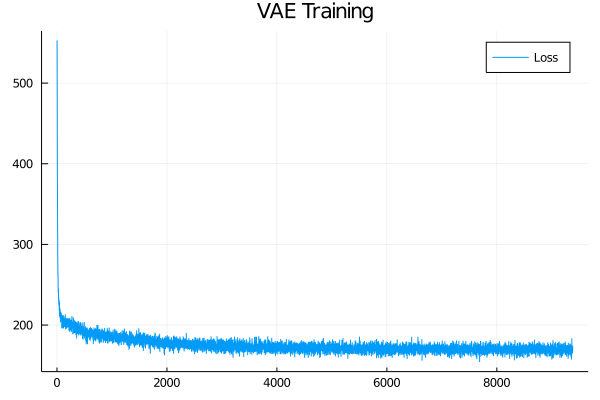

In [78]:
plot(1:length(train_losses), train_losses, title = "VAE Training", label = "Loss")

In [75]:
?plot

search: plot plot! plotly plot3d Plots plot3d! plotlyjs plotattr plotarea



The main plot command. Use `plot` to create a new plot object, and `plot!` to add to an existing one:

```
    plot(args...; kw...)                  # creates a new plot window, and sets it to be the current
    plot!(args...; kw...)                 # adds to the `current`
    plot!(plotobj, args...; kw...)        # adds to the plot `plotobj`
```

There are lots of ways to pass in data, and lots of keyword arguments... just try it and it will likely work as expected. When you pass in matrices, it splits by columns. To see the list of available attributes, use the `plotattr([attr])` function, where `attr` is the symbol `:Series:`, `:Subplot:`, `:Plot` or `:Axis`. Pass any attribute to `plotattr` as a String to look up its docstring; e.g. `plotattr("seriestype")`.
